In [8]:
import numpy as np
import random
import math
import h5py
import gc
import sys
import matplotlib.mlab as mlab
import pylab as pl
from collections import OrderedDict
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf

In [2]:
hdf_file = 'datasets/pickles/SVHN_multi_box.hdf5'

hdf = h5py.File(hdf_file,'r')
svhn_train_box_dataset = hdf['train_images'][:]
svhn_train_box_labels = hdf['train_labels'][:]
svhn_test_box_dataset = hdf['test_images'][:]
svhn_test_box_labels = hdf['test_labels'][:]
svhn_valid_box_dataset = hdf['valid_images'][:]
svhn_valid_box_labels = hdf['valid_labels'][:]
            
hdf.close()    

print(svhn_train_box_dataset.shape, svhn_train_box_labels.shape)
print(svhn_test_box_dataset.shape, svhn_test_box_labels.shape)
print(svhn_valid_box_dataset.shape, svhn_valid_box_labels.shape)

(230070, 32, 96, 1) (230070, 6)
(13068, 32, 96, 1) (13068, 6)
(5684, 32, 96, 1) (5684, 6)


In [26]:
def plot_img(im, label):
    if len(im.shape) >= 3:
        im = im[:,:,0]
    plt.imshow(im)
    plt.title(label)
    plt.show()
    
def plot(i, d=0):
    if d == 2:
        plot_img(svhn_valid_box_dataset[i], svhn_valid_box_labels[i])
    elif d == 1:
        plot_img(svhn_test_box_dataset[i], svhn_test_box_labels[i])
    else :
        plot_img(svhn_train_box_dataset[i], svhn_train_box_labels[i])

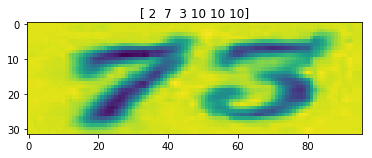

In [27]:
plot(16)

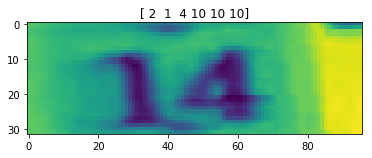

In [29]:
plot(46, 1)

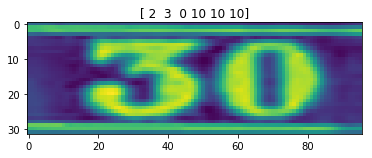

In [31]:
plot(78, 2)

In [10]:
def get_label_dist(labels_data):
    ddict = {}
    for i in range(labels_data.shape[0]):
        l = labels_data[i][0]
        if not l in ddict:
            ddict[l] = 0
        ddict[l] = ddict[l] + 1
    return ddict

In [11]:
train_label_dict = get_label_dist(svhn_train_box_labels)
test_label_dict = get_label_dist(svhn_test_box_labels)
valid_label_dict = get_label_dist(svhn_valid_box_labels)

In [18]:
def hist_dict(dict) :
    dict = OrderedDict(sorted(dict.items()))
    X = np.arange(len(dict))
    pl.bar(X, dict.values(), align='center', width=0.5)
    pl.xticks(X, dict.keys())
    ymax = max(dict.values()) + 1000
    pl.ylim(0, ymax)
    pl.show()

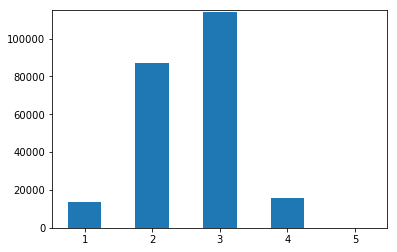

In [19]:
hist_dict(train_label_dict)

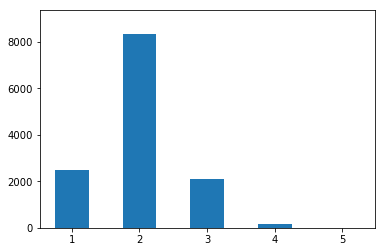

In [20]:
hist_dict(test_label_dict)

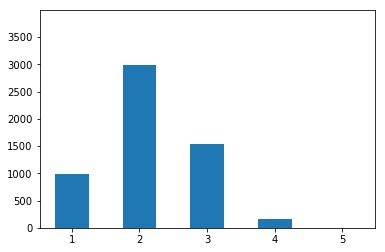

In [21]:
hist_dict(valid_label_dict)

In [2]:
hdf_file = 'datasets/pickles/SVHN_multi.hdf5'

hdf = h5py.File(hdf_file,'r')
svhn_test_dataset = hdf['test_images'][:]
svhn_test_labels = hdf['test_labels'][:]
svhn_train_dataset = hdf['train_images'][:]
svhn_train_labels = hdf['train_labels'][:]
svhn_valid_dataset = hdf['valid_images'][:]
svhn_valid_labels = hdf['valid_labels'][:]

hdf.close()    

print(svhn_train_dataset.shape, svhn_train_labels.shape)
print(svhn_test_dataset.shape, svhn_test_labels.shape)
print(svhn_valid_dataset.shape, svhn_valid_labels.shape)

(230255, 32, 96, 1) (230255, 6)
(13068, 32, 96, 1) (13068, 6)
(5500, 32, 96, 1) (5500, 6)


In [20]:
gc.collect()

0

In [3]:
%whos

Variable             Type        Data/Info
------------------------------------------
Image                module      <module 'PIL.Image' from <...>e-packages/PIL/Image.py'>
gc                   module      <module 'gc' (built-in)>
h5py                 module      <module 'h5py' from '/hom<...>ckages/h5py/__init__.py'>
hdf                  File        <Closed HDF5 file>
hdf_file             str         datasets/pickles/SVHN_multi.hdf5
imshow               function    <function imshow at 0x7fb69e53f730>
math                 module      <module 'math' from '/hom<...>35m-x86_64-linux-gnu.so'>
np                   module      <module 'numpy' from '/ho<...>kages/numpy/__init__.py'>
pickle               module      <module 'pickle' from '/h<...>lib/python3.5/pickle.py'>
plt                  module      <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
random               module      <module 'random' from '/h<...>lib/python3.5/random.py'>
svhn_test_dataset    ndarray     13068x32x96x1

In [22]:
del svhn_test_box_dataset, svhn_test_box_labels, svhn_train_box_dataset, svhn_train_box_labels, svhn_valid_box_dataset, svhn_valid_box_labels

In [25]:
% whos

Variable             Type         Data/Info
-------------------------------------------
B1                   Variable     Tensor("Variable_1/read:0<...>hape=(6,), dtype=float32)
B2                   Variable     Tensor("Variable_3/read:0<...>ape=(12,), dtype=float32)
B3                   Variable     Tensor("Variable_5/read:0<...>ape=(24,), dtype=float32)
B4                   Variable     Tensor("Variable_17/read:<...>pe=(200,), dtype=float32)
B5_1                 Variable     Tensor("Variable_7/read:0<...>ape=(11,), dtype=float32)
B5_2                 Variable     Tensor("Variable_9/read:0<...>ape=(11,), dtype=float32)
B5_3                 Variable     Tensor("Variable_11/read:<...>ape=(11,), dtype=float32)
B5_4                 Variable     Tensor("Variable_13/read:<...>ape=(11,), dtype=float32)
B5_5                 Variable     Tensor("Variable_15/read:<...>ape=(11,), dtype=float32)
HEIGHT               int          32
Image                module       <module 'PIL.Image' from <...>e

In [4]:
sys.getsizeof(pickle)

80

In [23]:
gc.collect()

0

In [5]:
svhn_train_dataset = svhn_train_dataset.astype(np.float32)
svhn_test_dataset = svhn_test_dataset.astype(np.float32)
svhn_valid_dataset = svhn_valid_dataset.astype(np.float32)

svhn_train_labels = svhn_train_labels.astype(np.int32)
svhn_test_labels = svhn_test_labels.astype(np.int32)
svhn_valid_labels = svhn_valid_labels.astype(np.int32)

In [32]:
print(svhn_train_dataset.shape, svhn_train_labels.shape)
print(svhn_test_dataset.shape, svhn_test_labels.shape)
print(svhn_valid_dataset.shape, svhn_valid_labels.shape)

(230255, 32, 96, 1) (230255, 6)
(13068, 32, 96, 1) (13068, 6)
(5500, 32, 96, 1) (5500, 6)


In [10]:
svhn_train_dataset, svhn_train_labels = randomize_dataset(svhn_train_dataset, svhn_train_labels)
svhn_test_dataset, svhn_test_labels = randomize_dataset(svhn_test_dataset, svhn_test_labels)
svhn_valid_dataset, svhn_valid_labels = randomize_dataset(svhn_valid_dataset, svhn_valid_labels)

In [11]:
svhn_train_dataset_1 = svhn_train_dataset[0:125000]
svhn_train_labels_1 = svhn_train_labels[0:125000]

print(svhn_train_dataset_1.shape, svhn_train_labels_1.shape)
print(svhn_train_dataset.shape, svhn_train_labels.shape)
print(svhn_test_dataset.shape, svhn_test_labels.shape)
print(svhn_valid_dataset.shape, svhn_valid_labels.shape)

(125000, 32, 96, 1) (125000, 6)
(230255, 32, 96, 1) (230255, 6)
(13068, 32, 96, 1) (13068, 6)
(5500, 32, 96, 1) (5500, 6)


In [4]:
def acc(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [5]:
def randomize_dataset(images, labels):
    shuffle = list(zip(images, labels))
    np.random.shuffle(shuffle)
    i, l = zip(*shuffle)
    i, l = np.asarray(i), np.asarray(l)
    return i, l

In [6]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

In [3]:
svhn_train_box_dataset = svhn_train_box_dataset.astype(np.float32)
svhn_test_box_dataset = svhn_test_box_dataset.astype(np.float32)
svhn_valid_box_dataset = svhn_valid_box_dataset.astype(np.float32)

svhn_train_box_labels = svhn_train_box_labels.astype(np.int32)
svhn_test_box_labels = svhn_test_box_labels.astype(np.int32)
svhn_valid_box_labels = svhn_valid_box_labels.astype(np.int32)

In [16]:
graph_svhn = tf.Graph()

with graph_svhn.as_default():
    HEIGHT = 32
    WIDTH = 32*3
    
    X = tf.placeholder(tf.float32, [None, HEIGHT, WIDTH, 1])
    Y_ = tf.placeholder(tf.int32, [None, 6])
    
    # Learning Rate - alpha
    alpha = tf.placeholder(tf.float32)
    
    # Dropout Probablity
    pkeep = tf.placeholder(tf.float32)
    
    # 5 Layers and their no of neurons
    # 3 Convolutional Layers and a fully connected layer
    K = 6     # First Conv Layer with depth 6
    L = 12     # Second Conv Layer with depth 12
    M = 24    # Third Conv layer with depth 24
    N = 200   # Fourth Fully Connected layer with 200 neurons
    # Last one will be softmax layer with 10 output channels
    
    W1 = tf.Variable(tf.truncated_normal([6, 6, 1, K], stddev=0.1), name="W1")    # 6x6 patch, 1 input channel, K output channels
    B1 = tf.Variable(tf.constant(0.1, tf.float32, [K]), name="B1")
    
    W2 = tf.Variable(tf.truncated_normal([5, 5, K, L], stddev=0.1), name="W2")
    B2 = tf.Variable(tf.constant(0.1, tf.float32, [L]), name="B2")
    
    W3 = tf.Variable(tf.truncated_normal([4, 4, L, M], stddev=0.1), name="W3")
    B3 = tf.Variable(tf.constant(0.1, tf.float32, [M]), name="B3")
    
    W5_1 = tf.Variable(tf.truncated_normal([N, 11], stddev=0.1), name="W5_1")
    B5_1 = tf.Variable(tf.constant(0.1, tf.float32, [11]), name="B5_1")
    
    W5_2 = tf.Variable(tf.truncated_normal([N, 11], stddev=0.1), name="W5_2")
    B5_2 = tf.Variable(tf.constant(0.1, tf.float32, [11]), name="B5_2")
    
    W5_3 = tf.Variable(tf.truncated_normal([N, 11], stddev=0.1), name="W5_3")
    B5_3 = tf.Variable(tf.constant(0.1, tf.float32, [11]), name="B5_3")
    
    W5_4 = tf.Variable(tf.truncated_normal([N, 11], stddev=0.1), name="W5_4")
    B5_4 = tf.Variable(tf.constant(0.1, tf.float32, [11]), name="B5_4")
    
    W5_5 = tf.Variable(tf.truncated_normal([N, 11], stddev=0.1), name="W5_5")
    B5_5 = tf.Variable(tf.constant(0.1, tf.float32, [11]), name="B5_5")
    
    # Model
    stride = 1  # output is 32x96
    Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME') + B1)
    
    stride = 2  # output is 16x48
    Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME') + B2)
    
    stride = 2  # output is 8x24
    Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME') + B3)

    # reshape the output from the third convolution for the fully connected layer
    shape = Y3.get_shape().as_list()
    YY = tf.reshape(Y3, shape=[-1, shape[1] * shape[2] * shape[3]])
    
    W4 = tf.Variable(tf.truncated_normal([shape[1] * shape[2] * shape[3], N], stddev=0.1), name="W4")
    B4 = tf.Variable(tf.constant(0.1, tf.float32, [N]), name="B4")

    Y4 = tf.sigmoid(tf.matmul(YY, W4) + B4)
    YY4 = tf.nn.dropout(Y4, pkeep)
    
    Ylogits_1 = tf.matmul(YY4, W5_1) + B5_1
    Ylogits_2 = tf.matmul(YY4, W5_2) + B5_2
    Ylogits_3 = tf.matmul(YY4, W5_3) + B5_3
    Ylogits_4 = tf.matmul(YY4, W5_4) + B5_4
    Ylogits_5 = tf.matmul(YY4, W5_5) + B5_5   
    ## ('Ylogits_1 shape : ', [None, 11])
    
    Y_1 = tf.nn.softmax(Ylogits_1)
    Y_2 = tf.nn.softmax(Ylogits_2)
    Y_3 = tf.nn.softmax(Ylogits_3)
    Y_4 = tf.nn.softmax(Ylogits_4)
    Y_5 = tf.nn.softmax(Ylogits_5)
   
    cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(Ylogits_1, Y_[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(Ylogits_2, Y_[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(Ylogits_3, Y_[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(Ylogits_4, Y_[:,4])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(Ylogits_5, Y_[:,5]))

    train_prediction = tf.pack([Y_1, Y_2, Y_3, Y_4, Y_5])
    
    train_step = tf.train.AdamOptimizer(alpha).minimize(cross_entropy)
    
    W_s = tf.pack([tf.reduce_max(tf.abs(W1)),tf.reduce_max(tf.abs(W2)),tf.reduce_max(tf.abs(W3)),tf.reduce_max(tf.abs(W4))])
    b_s = tf.pack([tf.reduce_max(tf.abs(B1)),tf.reduce_max(tf.abs(B2)),tf.reduce_max(tf.abs(B3)),tf.reduce_max(tf.abs(B4))])
    
    model_saver = tf.train.Saver()

In [17]:
train_data = svhn_train_box_dataset
label_data = svhn_train_box_labels
print('train : ', train_data.shape, '  test : ', label_data.shape)

num_steps_1 = 15001
batch_size = 128

with tf.Session(graph=graph_svhn) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    
    for step in range(num_steps_1):
        #  learning rate decay
        max_learning_rate = 0.0005
        min_learning_rate = 0.0001

        decay_speed = 5000.0
        learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-step/decay_speed)
        offset = (step * batch_size) % (label_data.shape[0] - batch_size)
        batch_data = train_data[offset:(offset + batch_size), :, :, :]
        batch_labels = label_data[offset:(offset + batch_size), :]
        
        feed_dict = {X : batch_data, Y_ : batch_labels, pkeep : 0.80, alpha : learning_rate}
        _, l, train_pred, W, b = session.run([train_step, cross_entropy, train_prediction, W_s, b_s], feed_dict=feed_dict)
    
        if (step % 500 == 0):
            print('W : ', W)
            print('b : ', b)
            print('Loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % acc(train_pred, batch_labels[:,1:6]))
            print('Learning rate : ', learning_rate)
            print('    ')
            
    print('Training Complete on SVHN Data')
    
    save_path = model_saver.save(session, "saved_models/box/CNN_SVHN_Box.ckpt")
    print("Model saved in file: %s" % save_path)

train :  (230069, 32, 96, 1)   test :  (230069, 6)
Initialized
W :  [ 0.19912431  0.19984199  0.19993149  0.19999866]
b :  [ 0.1  0.1  0.1  0.1]
Loss at step 0: 10.998222
Minibatch accuracy: 25.6%
Learning rate :  0.0005
    
W :  [ 0.27869901  0.28080469  0.31645367  0.29588386]
b :  [ 0.10715443  0.10085165  0.10796183  0.10712352]
Loss at step 500: 3.978148
Minibatch accuracy: 76.1%
Learning rate :  0.00046193496721438383
    
W :  [ 0.29005209  0.336739    0.36391553  0.36647207]
b :  [ 0.13026245  0.09765711  0.11307368  0.10726233]
Loss at step 1000: 2.775166
Minibatch accuracy: 83.4%
Learning rate :  0.00042749230123119273
    
W :  [ 0.29654711  0.36784068  0.39701965  0.38761118]
b :  [ 0.14628613  0.11255246  0.12173833  0.10971935]
Loss at step 1500: 2.475353
Minibatch accuracy: 84.4%
Learning rate :  0.00039632728827268716
    
W :  [ 0.29915556  0.38268748  0.42087078  0.41162404]
b :  [ 0.18033437  0.13236335  0.14346537  0.1101019 ]
Loss at step 2000: 2.095910
Minibatch 

In [19]:
with tf.Session(graph=graph_svhn) as session: 
    print('Initialized')
    batch = 1000
    
    test_acc = list()
    print('-------TEST--------')
    test_no = int(svhn_test_box_labels.shape[0] / batch)
    for i in range(test_no - 1):
        model_saver.restore(session, "saved_models/box/CNN_SVHN_Box.ckpt")
        data = svhn_test_box_dataset[i*batch:(i+1)*batch]
        labels = svhn_test_box_labels[i*batch:(i+1)*batch]
        
        _, l, predictions = session.run([train_step, cross_entropy, train_prediction], feed_dict={X : data, Y_ : labels, pkeep : 1.0, alpha : 0.002})
        accuracy = acc(predictions, labels[:,1:6])
        test_acc.append(accuracy)
        
        print('Test-Accuracy', ' i : ', i)
        print('Test accuracy: ', accuracy)
        print('       ')
    
    valid_acc = list()
    print('-----VALIDIDATION------')
    valid_no = int(svhn_valid_box_labels.shape[0] /  batch)
    for i in range(valid_no - 1):
        model_saver.restore(session, "saved_models/box/CNN_SVHN_Box.ckpt")
        data = svhn_valid_box_dataset[i*batch:(i+1)*batch]
        labels = svhn_valid_box_labels[i*batch:(i+1)*batch]
        
        _, l, predictions = session.run([train_step, cross_entropy, train_prediction], feed_dict={X : data, Y_ : labels, pkeep : 1.0, alpha : 0.002})
        accuracy = acc(predictions, labels[:,1:6])
        valid_acc.append(accuracy)
        
        print('Valid-Accuracy', ' i : ', i)
        print('Valid accuracy: ', accuracy)
        print('        ')
        
        
    test_avg = mean(test_acc)
    valid_avg = mean(valid_acc)
    
    print('-----  FINAL  ------')
    print('Final Test Set Accuracy : ',"%.2f" % test_avg)
    print('Final Validation Set Accuracy : ',"%.2f" % valid_avg)

Initialized
-------TEST--------
Test-Accuracy  i :  0
Test accuracy:  92.6
       
Test-Accuracy  i :  1
Test accuracy:  93.82
       
Test-Accuracy  i :  2
Test accuracy:  93.28
       
Test-Accuracy  i :  3
Test accuracy:  93.66
       
Test-Accuracy  i :  4
Test accuracy:  93.52
       
Test-Accuracy  i :  5
Test accuracy:  93.5
       
Test-Accuracy  i :  6
Test accuracy:  93.42
       
Test-Accuracy  i :  7
Test accuracy:  92.86
       
Test-Accuracy  i :  8
Test accuracy:  93.26
       
Test-Accuracy  i :  9
Test accuracy:  93.16
       
Test-Accuracy  i :  10
Test accuracy:  93.28
       
Test-Accuracy  i :  11
Test accuracy:  92.72
       
-----VALIDIDATION------
Valid-Accuracy  i :  0
Valid accuracy:  93.62
        
Valid-Accuracy  i :  1
Valid accuracy:  93.74
        
Valid-Accuracy  i :  2
Valid accuracy:  92.04
        
Valid-Accuracy  i :  3
Valid accuracy:  92.24
        
-----  FINAL  ------
Final Test Set Accuracy :  93.26
Final Validation Set Accuracy :  92.91


In [24]:
train_data = svhn_train_box_dataset
label_data = svhn_train_box_labels
print('train : ', train_data.shape, '  test : ', label_data.shape)

num_steps_1 = 25001
batch_size = 128

with tf.Session(graph=graph_svhn) as session:
    model_saver.restore(session, "saved_models/box/CNN_SVHN_Box.ckpt")
    print('Initialized')
    
    W1 = session.run(W1)
    print(W1)

train :  (230069, 32, 96, 1)   test :  (230069, 6)
Initialized
[[[[  4.55973335e-02   1.53596615e-04   5.00065014e-02   1.53114200e-01
     -1.94633991e-01   1.69345438e-01]]

  [[  2.03227594e-01  -1.21700525e-01   1.57479178e-02   1.93776503e-01
     -1.17192507e-01   3.59971933e-02]]

  [[  3.92683409e-02   5.16165569e-02   9.49823037e-02   2.46617105e-02
     -7.75151774e-02   1.33930728e-01]]

  [[ -2.34469771e-02   6.16568476e-02   5.60287125e-02   1.43649548e-01
     -1.48194535e-02  -7.61023611e-02]]

  [[ -2.96078753e-02  -1.03850670e-01   9.46090743e-02  -1.59331933e-02
      7.82122463e-03   6.80771796e-03]]

  [[ -1.45946786e-01  -4.58083348e-04   3.16846848e-01   6.82488382e-02
      1.25840396e-01  -3.08791772e-02]]]


 [[[  1.93741888e-01  -4.96291481e-02  -1.62550509e-01   1.23338558e-01
      3.02333049e-02   1.34490475e-01]]

  [[  6.05372079e-02  -1.62835959e-02  -9.73284990e-02  -3.60536650e-02
     -1.41874477e-02   6.84804320e-02]]

  [[  7.25641754e-03   2.143293

In [22]:
train_data = svhn_train_dataset_1
label_data = svhn_train_labels_1
print('train : ', train_data.shape, '  test : ', label_data.shape)

num_steps_1 = 3001
batch_size = 128

with tf.Session(graph=graph_svhn) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    
    for step in range(num_steps_1):
        #  learning rate decay
        max_learning_rate = 0.0005
        min_learning_rate = 0.0001
        decay_speed = 5000.0
        learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-step/decay_speed)
        offset = (step * batch_size) % (label_data.shape[0] - batch_size)
        batch_data = train_data[offset:(offset + batch_size), :, :, :]
        batch_labels = label_data[offset:(offset + batch_size), :]
        
        feed_dict = {X : batch_data, Y_ : batch_labels, pkeep : 0.80, alpha : learning_rate}
        _, l, train_pred, W, b = session.run([train_step, cross_entropy, train_prediction, W_s, b_s], feed_dict=feed_dict)

        if (step % 500 == 0):
            print('W : ', W)
            print('b : ', b)
            print('Loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % acc(train_pred, batch_labels[:,1:6]))
            print('Learning rate : ', learning_rate)
            print('    ')
            
    print('Training Complete on SVHN Data')
    
    save_path = model_saver.save(session, "saved_models/multi/CNN_SVHN_New.ckpt")
    print("Model saved in file: %s" % save_path)

train :  (125000, 32, 96, 1)   test :  (125000, 6)
Initialized
W :  [ 0.1957577   0.19950426  0.19999866  0.19999957]
b :  [ 0.1  0.1  0.1  0.1]
Loss at step 0: 15.812104
Minibatch accuracy: 3.4%
Learning rate :  0.0005
    
W :  [ 0.20176931  0.20336588  0.21233326  0.21602039]
b :  [ 0.09924942  0.11802243  0.11003009  0.11306362]
Loss at step 500: 6.913124
Minibatch accuracy: 53.9%
Learning rate :  0.00046193496721438383
    
W :  [ 0.20172596  0.20614482  0.21922968  0.232022  ]
b :  [ 0.10019359  0.12345539  0.11821508  0.1157744 ]
Loss at step 1000: 6.926769
Minibatch accuracy: 54.4%
Learning rate :  0.00042749230123119273
    
W :  [ 0.20099458  0.20611057  0.22664881  0.24046591]
b :  [ 0.10177581  0.12987101  0.11949582  0.11835108]
Loss at step 1500: 6.856278
Minibatch accuracy: 53.8%
Learning rate :  0.00039632728827268716
    
W :  [ 0.19851771  0.20685558  0.23405121  0.24046807]
b :  [ 0.10594938  0.12891285  0.12108289  0.11941691]
Loss at step 2000: 6.854865
Minibatch a

In [25]:
with tf.Session(graph=graph_svhn) as session:
    model_saver.restore(session, "saved_models/multi/CNN_SVHN_New.ckpt")
    print("Model restored.") 
    print('Initialized')
    
    print(session.run(W1))

Model restored.
Initialized
[[[[ 0.06091791  0.0327538  -0.19416073 -0.01676372  0.02233364 -0.02901404]]

  [[-0.04115827 -0.00266697  0.10546505  0.03128034 -0.02302971  0.03785209]]

  [[ 0.02321358 -0.08577943 -0.07981791  0.19747455 -0.06205473  0.06701094]]

  [[-0.02935915 -0.09522378  0.05649186  0.08751354 -0.05960583 -0.07666398]]

  [[-0.14650303  0.17145529 -0.00110248  0.04165018  0.01372952  0.02088568]]

  [[ 0.01313367  0.00348472 -0.12836632  0.01750273 -0.06433355 -0.1076489 ]]]


 [[[ 0.01552692  0.19806165  0.01933289 -0.14826033 -0.04317336 -0.09452876]]

  [[ 0.04372241 -0.17828043  0.10888292  0.01148719 -0.05250533 -0.02962187]]

  [[-0.00225709 -0.13161032 -0.05115749  0.03142713  0.173245   -0.01677104]]

  [[-0.15817691 -0.09034646 -0.07150197 -0.16240661  0.06633522  0.05496876]]

  [[ 0.01151476 -0.12420844  0.02609648  0.12235687  0.0465115  -0.04505098]]

  [[ 0.0315448   0.05198722 -0.04371455  0.01141434  0.14327204  0.00390389]]]


 [[[ 0.03091958  0.0

In [24]:
with tf.Session(graph=graph_svhn) as session:
    model_saver.restore(session, "saved_models/box/CNN_SVHNox_.ckpt")
    print("Model restored.") 
    print('Initialized')
    
    print(session.run([W1]))

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for saved_models/box/CNN_SVHNox_.ckpt
	 [[Node: save/RestoreV2_17 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_17/tensor_names, save/RestoreV2_17/shape_and_slices)]]
	 [[Node: save/RestoreV2_12/_3 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_140_save/RestoreV2_12", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'save/RestoreV2_17', defined at:
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-e7059acaa63f>", line 91, in <module>
    model_saver = tf.train.Saver(var_list)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1000, in __init__
    self.build()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1030, in build
    restore_sequentially=self._restore_sequentially)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 624, in build
    restore_sequentially, reshape)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 361, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 200, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 441, in restore_v2
    dtypes=dtypes, name=name)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to find any matching files for saved_models/box/CNN_SVHNox_.ckpt
	 [[Node: save/RestoreV2_17 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_17/tensor_names, save/RestoreV2_17/shape_and_slices)]]
	 [[Node: save/RestoreV2_12/_3 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_140_save/RestoreV2_12", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


In [ ]:
with tf.Session(graph=graph_svhn) as session:
    model_saver.restore(session, "saved_models/multi/CNN_SVHN_New.ckpt")
    print("Model restored.") 
    print('Initialized')
    
    _, l, predictions = session.run([train_step, cross_entropy, train_prediction], feed_dict={X : svhn_test_dataset[:500], Y_ : svhn_test_labels[:500], pkeep : 1.0, alpha : 0.002})
    print('Test accuracy: ', acc(predictions, svhn_test_labels[:500,1:6]))
    
    del l, predictions
    _, l, predictions = session.run([train_step, cross_entropy, train_prediction], feed_dict={X : svhn_valid_dataset, Y_ : svhn_valid_labels, pkeep : 1.0, alpha : 0.002})
    print('Validation accuracy: ', acc(predictions, svhn_valid_labels[:,1:6]))

In [13]:
train_data = svhn_train_dataset_1
label_data = svhn_train_labels_1
print('train : ', train_data.shape, '  test : ', label_data.shape)

num_steps_1 = 20001
batch_size = 128

with tf.Session(graph=graph_svhn) as session:
    model_saver.restore(session, "saved_models/box/CNN_SVHN_Box.ckpt")
    print("Model restored.") 
#     tf.global_variables_initializer().run()
    print('Initialized')
    
    for step in range(num_steps_1):
        #  learning rate decay
        max_learning_rate = 0.0005
        min_learning_rate = 0.0001
        decay_speed = 5000.0
        learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-step/decay_speed)
        offset = (step * batch_size) % (label_data.shape[0] - batch_size)
        batch_data = train_data[offset:(offset + batch_size), :, :, :]
        batch_labels = label_data[offset:(offset + batch_size), :]
        
        feed_dict = {X : batch_data, Y_ : batch_labels, pkeep : 0.80, alpha : learning_rate}
        _, l, train_pred, W, b = session.run([train_step, cross_entropy, train_prediction, W_s, b_s], feed_dict=feed_dict)
    
        if (step % 500 == 0):
            print('W : ', W)
            print('b : ', b)
            print('Loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % acc(train_pred, batch_labels[:,1:6]))
            print('Learning rate : ', learning_rate)
            print('    ')
            
    print('Training Complete on SVHN Data')
    
    save_path = model_saver.save(session, "saved_models/combined/CNN_SVHN_Mix.ckpt")
    print("Model saved in file: %s" % save_path)

train :  (125000, 32, 96, 1)   test :  (125000, 6)
Model restored.
Initialized
W :  [ 0.41171086  0.69925141  0.47237745  0.7207135 ]
b :  [ 0.53505075  0.31870961  0.45383301  0.12280813]
Loss at step 0: 54.654106
Minibatch accuracy: 16.9%
Learning rate :  0.0005
    
W :  [ 0.42643231  0.70004612  0.46439368  0.71949875]
b :  [ 0.53378701  0.31939578  0.45481381  0.12296873]
Loss at step 500: 8.034361
Minibatch accuracy: 52.0%
Learning rate :  0.00046193496721438383
    


KeyboardInterrupt: 